# Assignment 2 - Question 1
The objective of this assignment is to get you familiarize with  the  problem  of  `Clustering`.

## Instructions
- Write your code and analysis in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of other cells.
- No inbuilt functions to be used until specified

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>_Assignment2_Q1.ipynb`.

In [1]:
import nltk
nltk.download('punkt')    
# if u r facing issues while importing nltk, please uncomment above line and run
import re
import joblib
import numpy as np
import math
import sklearn
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.spatial.distance import cdist

[nltk_data] Downloading package punkt to /home/aryan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from sentence_transformers import SentenceTransformer

2022-02-18 22:16:04.123134: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-18 22:16:04.264367: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Dataset



*   Try to explore the dataset and first understand
*   Steps while processing the dataset:

1.   Load the dataset
>> The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: train and test. Here, we only use train part of the dataset as we don't need any training.

2.   pre-processing of the dataset
>>   A set of basic pre-processing steps are given below, if you can do it better, it is appreciable
3.   Trying to obtain the embeddings for the text. 
>> Here, we used bert model to obtain the embeddings, if you want to use anyother sentence/word embeddings (ELMo,universal sentence encoder, or other bert models) you can use it, but not mandatorily change it)

PS: You need not completely understand how bert works. If you are interested, few links will be mentioned below.

In [5]:
# loading of dataset

from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

# print(list(newsgroups_train))
#['data', 'filenames', 'target_names', 'target', 'DESCR']
# all we require for our task is data and target. 
#target_names describe the different groups present (which are 20) all over the dataset

# print(list(newsgroups_train.target_names))

In [9]:
print(len(newsgroups_train['data']))

11314


In [4]:
bert_model = SentenceTransformer('bert-base-nli-mean-tokens')

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [5]:
#preprocessing of sentences and the article
def remove_punct(text):
    text = re.sub('[^a-zA-Z0-9 ]+',' ', text)
    return text

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_tag(text):   
    html_pattern = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    text = html_pattern.sub(r'', text)
    text = re.sub(r"\S*@\S*\s?", '',text)
    return text

def pre_process_sentence(sentence):
    sentence = sentence.lower()
    # stripping is removing extra spaces from start and end of the sentence
    sentence = remove_punct(remove_urls(remove_tag(sentence))).strip()
    return sentence

def refine_text(text):
    sent = []
    str = ''
    f = 0
    for l in text:
        if l=='\n':
            if f==0:
                # adding a space, because after many full-stops, we don't have a space
                str+=' '
                sent.append(str)
            str=''
            f=0
        else:
            str+=l
            if l == ':':
                f=1

    pure_text = ''
    for sen in sent:
        pure_text += sen

    article = sent_tokenize(pure_text)
    return article

def pre_process_article(article):
    article = refine_text(article)
    sentences = []
    for each in article:
        sentences.append(pre_process_sentence(each))
    return sentences



In [6]:

def get_review_embedding(article):
    sentences = pre_process_article(article)

    #here review(input) has to be a list of sentences
    #use suitable embeddings to get an embedding for the whole review
    #usage of sentence embeddings is recommended

    sentence_embeddings = bert_model.encode(sentences)

    # take average of all sentence embeddings to obtain a review embedding 
    review_embedding = np.zeros(768)
    for each in sentence_embeddings:
        review_embedding = np.add(np.array(each), review_embedding)

    review_embedding /= len(sentence_embeddings)

    return review_embedding

In [ ]:
# running BERT on our newsgroups_train data and storing it in as pickle file
lst = []
length = len(newsgroups_train['data'])
for i in range(length):
    lst.append((get_review_embedding(newsgroups_train['data'][i]),newsgroups_train['target'][i]))
    print(i)

# dumping into pickle file
joblib.dump(lst, 'q1_vectors.pkl')

In [2]:
# the file is available at link: https://drive.google.com/file/d/15NXqIK0lkY9glSna8HY5VeUCAjO3yem-/view?usp=sharing
lst = joblib.load('q1_vectors.pkl')

In [3]:
X = []
y = []
for p in lst:
    # handling the NaN values
    f = 1
    for e in p[0]:
        if math.isnan(e):
            f=0
            break
    if f==1:
        X.append(p[0])
        y.append(p[1])

X = np.array(X)
y = np.array(y)

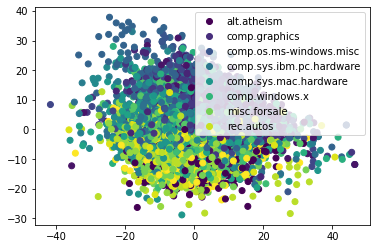

In [6]:
# data visualization 
# Try to visualise the points from all the domains and try to visualise them 
# hint: you can use PCA 

import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# we are able to visualize in 2d
pca = PCA(n_components=2)
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
Xt = pipe.fit_transform(X)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=y)
plt.legend(handles=plot.legend_elements()[0], labels=list(newsgroups_train['target_names']))
plt.show()

# K_Means Algorithm


In [22]:
# code to write your Kmeans algorithm
#implement your KMeans algorithm here, and visualise the clusters obtained 

from sklearn.cluster import KMeans

# Xt is obtained after applying PCA on X
label = KMeans(n_clusters=4, random_state=4).fit_predict(Xt)

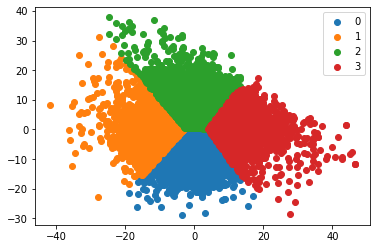

In [23]:
#code for visualisation of clusters
#Getting unique labels
u_labels = np.unique(label)
 
#plotting the results:
for i in u_labels:
    x = []
    y = []
    for j in range(len(Xt)):
        if label[j] == i:
            x.append(Xt[j][0])
            y.append(Xt[j][1])
    plt.scatter(x, y, label = i)
plt.legend()
plt.show()

# Elbow method



*   Try to understand how elbow method works
*   Plot the graph between average distance and the number of clusters
*   Use elbow method to find the optimal number of clusters, 







1
2
3
4
5
6
7
8
9


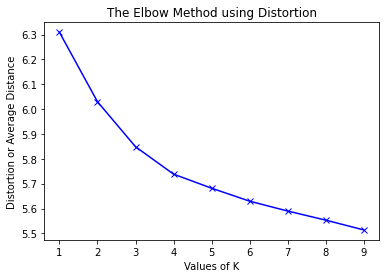

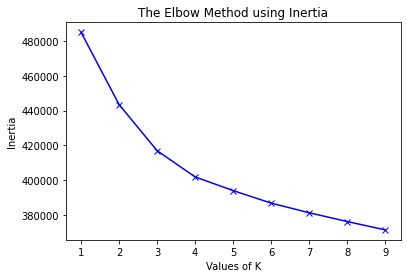

In [9]:
def elbow_method(X):
    distortions = []
    inertias = []
    K = range(1, 10)

    for k in K:
        # Building and fitting the model
        kmeanModel = KMeans(n_clusters=k).fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,'euclidean'), axis=1)) / X.shape[0])
        inertias.append(kmeanModel.inertia_)
        print(k)

    # Distortion     
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Distortion or Average Distance')
    plt.title('The Elbow Method using Distortion')
    plt.show()
    
    # Inertia     
    plt.plot(K, inertias, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Inertia')
    plt.title('The Elbow Method using Inertia')
    plt.show()
    
elbow_method(X)

We will pick the k after which both the graphs are linear. For the above the case, the value of k(number of clusters) should be 4.

# Silhouette Method


*   Compute silhouette score varying the K number of clusters

*   Plot the graph between silhoutte score and number of clusters 

*   Find the optimal number of clusters using silhouette method




> Report the optimal number of clusters you obtained from above two methods (elbow and silhouette)




Silhouette score for k=2 is 0.08219500250929095
Silhouette score for k=3 is 0.071774660995344
Silhouette score for k=4 is 0.06666644190917718
Silhouette score for k=5 is 0.03876943976877641
Silhouette score for k=6 is 0.038721166030523106
Silhouette score for k=7 is 0.03520801443276788
Silhouette score for k=8 is 0.0340466459910433
Silhouette score for k=9 is 0.032508003656874264


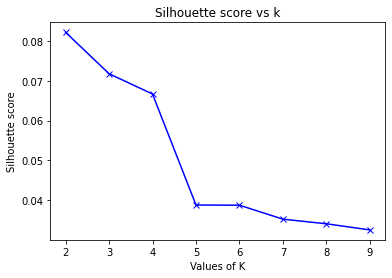

In [24]:
import seaborn as sns
from sklearn.metrics import silhouette_score

K = range(2, 10)
scores = []
for k in K:
    label = KMeans(n_clusters=k).fit_predict(X)
    score = silhouette_score(X, label,  metric='euclidean')
    scores.append(score)
    print('Silhouette score for k={} is {}'.format(k,score))
    

plt.plot(K, scores, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette score vs k')
plt.show()

From Silhouette method, the optimal k is 2, because the maximum score is obtained over there.

# Agglomerative clustering

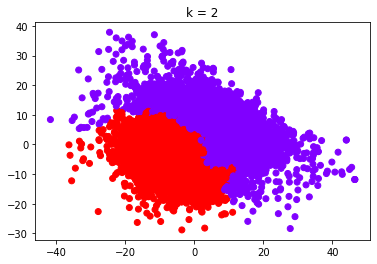

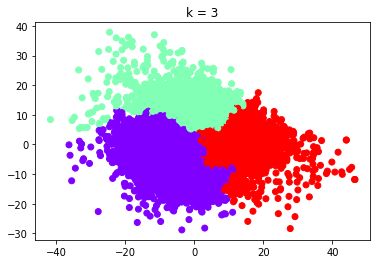

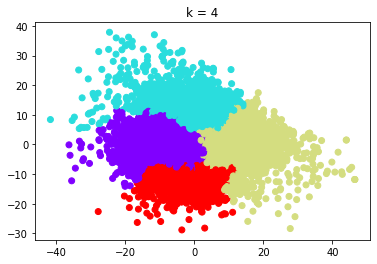

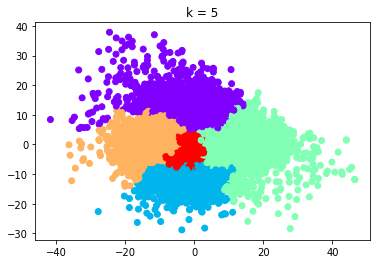

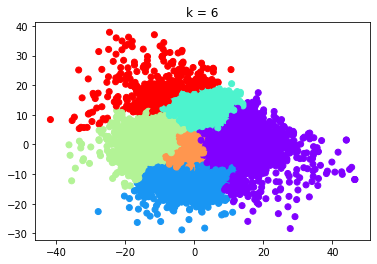

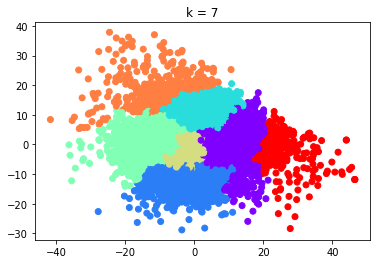

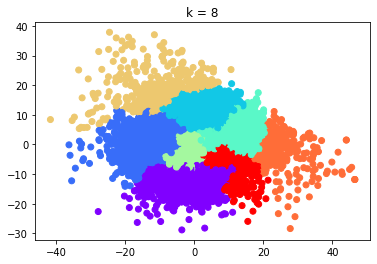

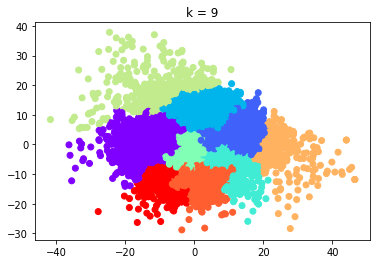

In [32]:
# code to write your Kmeans algorithm
#implement your KMeans algorithm here, and visualise the clusters obtained 

from sklearn.cluster import AgglomerativeClustering
x = []
y = []
for p in Xt:
    x.append(p[0])
    y.append(p[1])
K = range(2,10)
for k in K:
    ac = AgglomerativeClustering(n_clusters = k)
    # Visualizing the clustering
    plt.scatter(x,y,c = ac.fit_predict(Xt), cmap ='rainbow')
    plt.title('k = {}'.format(k))
    plt.show()

# Dendogram


*   Try to understand the difference between agglomerative clustering and divisive clustering

Ans) Hierarchical clustering analysis is a method of cluster analysis that seeks to build a hierarchy of clusters i.e. tree-type structure based on the hierarchy. 

2 types of hierarchical clustering:

a) Agglomerative Clustering: Also known as bottom-up approach or hierarchical agglomerative clustering (HAC). Bottom-up algorithms treat each data as a singleton cluster at the outset and then successively agglomerates pairs of clusters until all clusters have been merged into a single cluster that contains all data.

b) Divisive Clustering: Also known as a top-down approach. Top-down clustering requires a method for splitting a cluster that contains the whole data and proceeds by splitting clusters recursively until individual data have been split into singleton clusters.

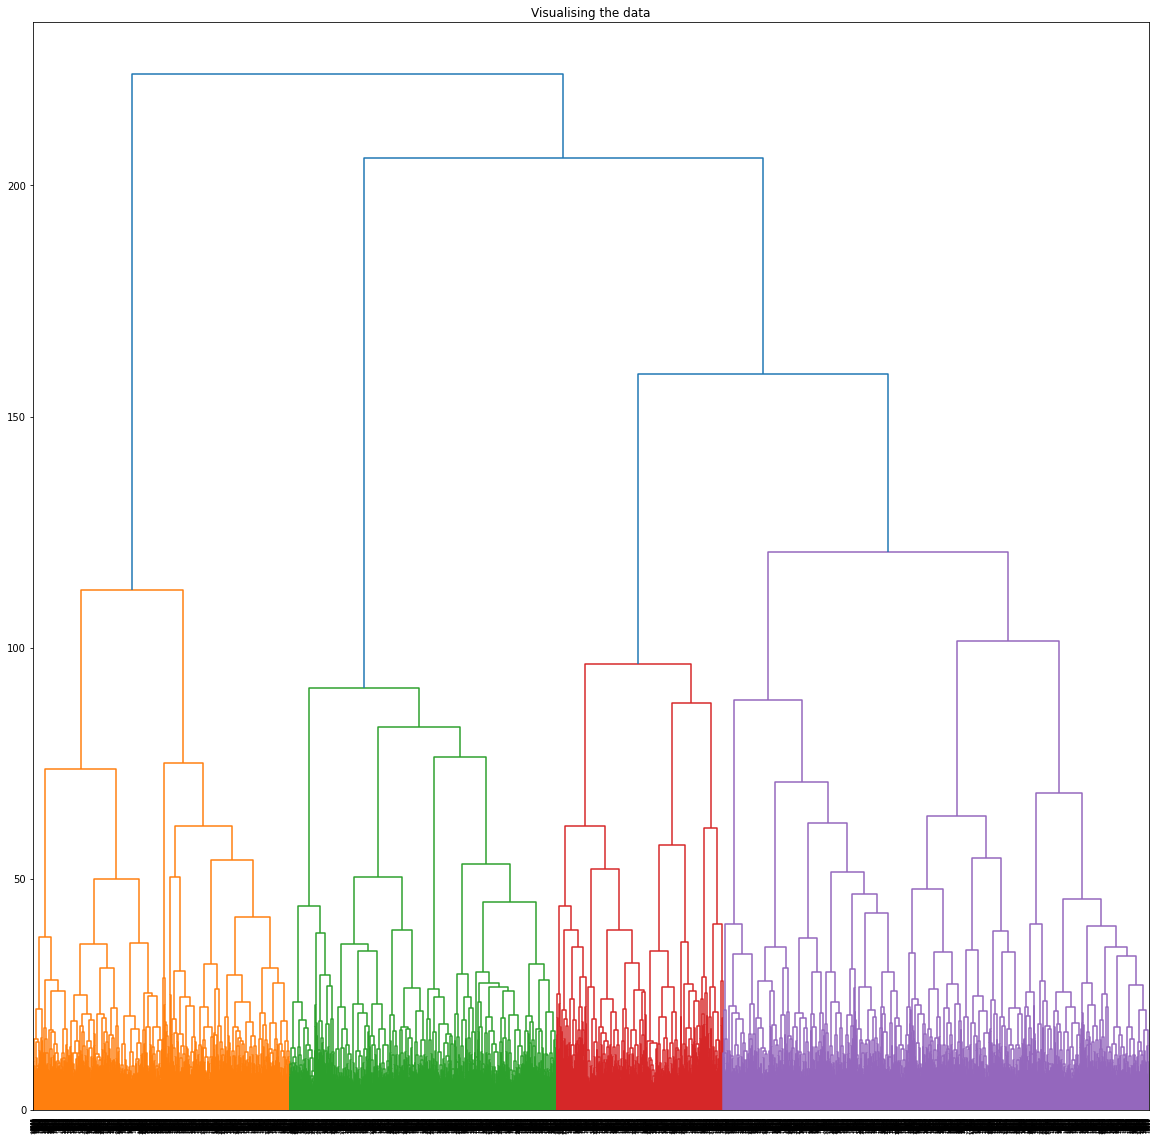

In [36]:
# code to write dendogram
import scipy.cluster.hierarchy as shc

plt.figure(figsize =(20, 20))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(X, method ='ward')))

*   Find the optimal number of clusters with the help of Dendogram

The optimal number of clusters from dendogram is 2, which was also the case in silhouette method.

By looking at the dendogram, the optimal number of clusters seems to be 2.

# useful links to understand BERT

*  https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270#:~:text=How%20BERT%20works,%2Dwords)%20in%20a%20text.&text=As%20opposed%20to%20directional%20models,sequence%20of%20words%20at%20once.


